# Simple SIR model of Covid-19
![SIR.png](SIR.png)

First import needed packages.

In [89]:
import Pkg;
Pkg.add("Plots");Pkg.add("PyPlot");Pkg.add("DifferentialEquations"); Pkg.add("CSV"); 
using Plots; using DifferentialEquations; using CSV;

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


Next define the model and a method that solves the system of ODEs.

In [5]:
function sir!(du,u,p,t)
 S,I,R = u
 N = S+I+R
 β,γ = p
 
 du[1] = -β*(I*S) / N
 du[2] = β*(I*S) / N - γ*I
 du[3] = γ*I
end

function simSir(β,γ)
   p = [β;γ]
   u0 = [99.0; 1.0; 0.0]
   tspan = (0.0,100.0)
   prob = ODEProblem(sir!,u0,tspan,p)
   sol = solve(prob)
   return sol
end;

I've set the population to be 100, with one infected and the rest susceptible. This is a continuous model, so we can think of these as percentages. The time variable we'll take to be days.

The parameter $\beta$ is the infectivity, the initial rate of increase in infection rate. Or $β = ln(2)/ \tau_d$ where $\tau_d$ is the doubling period. For Covid-19 in the US, the initial doubling period was around 3 days, so $\beta = .23$.

![NYT-covid.png](NYT-covid.png)
(Image from NY Times)

The parameter $\gamma$ is the recovery rate. "Recovered" here means "not contagious". There's a pre-symptomatic, but still contagioius, phase, that lasts around 5 days, and then the symptomatic phase. Many hospitals follow the guideline that patients are no longer contagious 7 days after symptom onset (assuming no fever for 2 days). Summing those and rounding to 2 weeks gives $\gamma=.07$.

These two parameters are related to $R_0$, the average number of people an infect person infects as $$R_0 = \beta / \gamma$$. Intuitively, more people will be infected the faster the infectious rate and the slower the recovery rate. The numbers above give $R_0 = 3.3$, which is in range of estimated values.

Putting these values in and plotting...

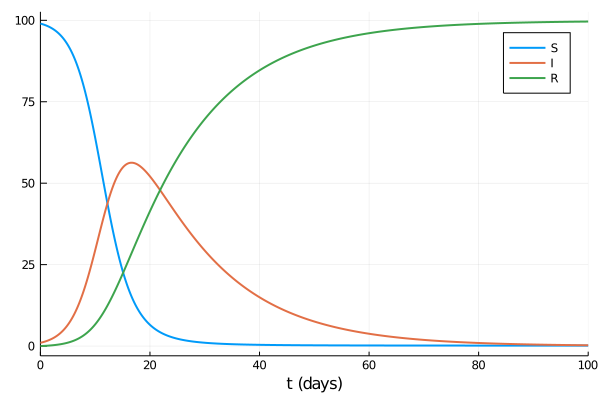

In [82]:

sol = simSir(.23*2,.07); 
plot(sol,linewidth=2,xaxis="t (days)", label=["S" "I" "R"])

The red infected curve looks qualitatively like the number of new cases, for example in China where the pandemic has progressed the furthest. However, we have no direct measure to distinguish infected from recovered. To compare the daily new cases to the model we need to look at the change in number of people who have ever had it, $I+R$...

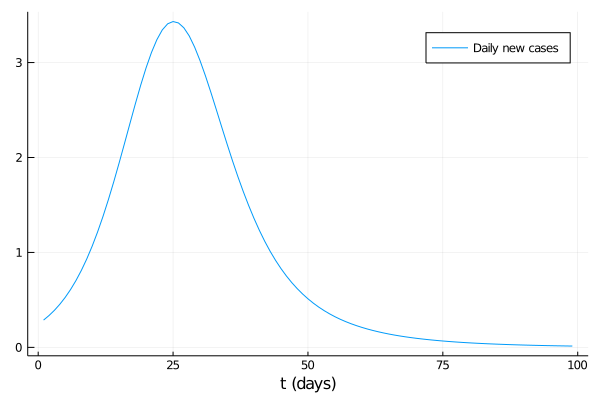

In [45]:
newCases = diff(map(x -> x[2] + x[3], sol(1:1:100).u))
plot(newCases, xaxis="t (days)", label="Daily new cases")

In [49]:
(_, t_peak) = findmax(newCases)

(3.431983804071237, 25)

The peak occurs after 26 dats (adding a day to offset the effect of `diff`), and the daily new cases at the peak corresponds to 3.4% of the population. Looking at NYC, the first case is reported on March 3. The peak in new cases occurred somewhere around April 2, which is more like 30 days, but still close. The daily new case rate around April 2 isi 6000/day. However, 6000 is only 0.07% of NYC's 8.4M population. The measured case rate is ~50X smaller than this model predicts.

Let's calculate the amount that have had the disease at the peak:

In [53]:
100 - sol(t_peak + 1)[1]

44.49707554827491

44% of the population! And this would be back on April 2. 

### Compare model to NYC data
How does the shape compare? Let's compare to the NYC data, which is available here https://www1.nyc.gov/site/doh/covid/covid-19-data.page

Day 1 corresponds to Mar 3, 2020.

In [67]:
nycDat = CSV.read("dataNYC.csv");

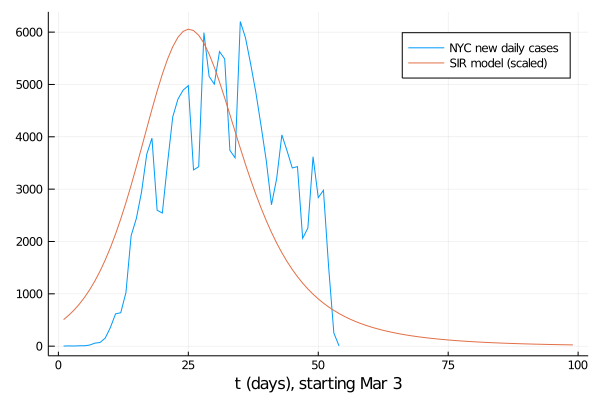

In [74]:
plot([nycDat.Cases, newCases/3.4*6000], xaxis="t (days), starting Mar 3", label=["NYC new daily cases" "SIR model (scaled)"])

I've scaled the model so that the peak is at approximately the same height. This would correspond to only about 2% of infected people getting tested. 

We can see the curves are shifted. It's plausible that a continuous model would only be expected to apply once there's a sufficiently large infected population. Here's they are plotted with the first day on Mar 8, vs Mar 3...

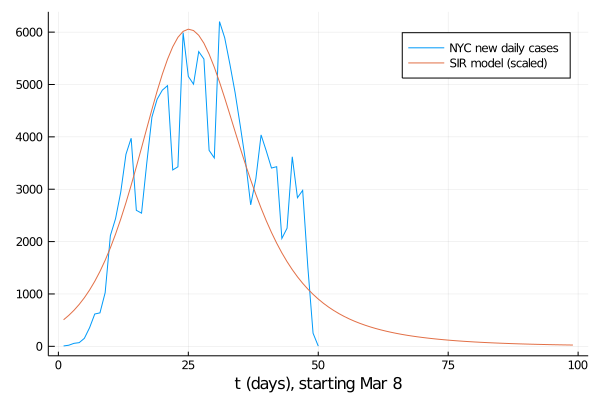

In [73]:
plot([nycDat.Cases[5:end], newCases/3.4*6000], xaxis="t (days), starting Mar 8", label=["NYC new daily cases" "SIR model (scaled)"])

The shape fits fairly well.

But what percentage would be infected now, on Day 50 (Apr 26)?

In [75]:
100 - sol(50)[1]

89.25187196176907

Hard to believe that nearly 90% of people would be infected by now. Antibody testing suggests the number is more like 13% https://www.nbcnewyork.com/news/local/2-7-million-in-new-york-may-have-been-infected-study-finds-nj-poised-to-top-100k-cases/2388182/ Note that 13% is about 7X higher than the official case count 1.8% (153k).

However, the simple SIR model would suggest that true number infected is another 7X on top of that. And this is for the hardest hit area in the US (and indeed the world). Many other places are peaking with a much lower fraction of those infected. For instance, Washington state had 10X fewer cases (and a similar population). 

Something is clearly missing in this model.  